# Tutorial for dlm regression with DLMMC

**In this notebook I walk through step-by-step how to read in your time-series and regressors, set-up and run the dlm, and process the outputs. If you are familiar with python it shouldn't take more than 15 minutes to read through this notebook (running the code as you go), and by the end I hope you will be geared up and ready to start running dlms on your own time-series data! So without further ado...**

## Import the required packages

TODO:
- [] run with AMO
- [] run for hi / low flow
- [] read the papers describing the models
- [] more intuitive questions of the data (currently only for ozone)
- [] assuming removing the correlation (IS THIS TRUE?)

In [22]:
# Import required modules
import pystan
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.interpolate as interpolate
import netCDF4
import pickle
import scipy.stats as stats
from utils.utils import *
%matplotlib inline

from pathlib import Path
import pandas as pd
import seaborn as sns


# Import the dlm model

**Note: make sure you have ran `compile_dlm_models.py` before you do this!**

**There are a number of models to choose from: the standard model below `dlm_vanilla_ar1` has a non-linear trend, seasonal cycle with 6- and 12-month components with time-varying amplitude and phase, regressor (proxy) variables and an AR1 process. This is usually a good starting point. For specific model descriptions see `models/model_descriptions.pdf`**

In [23]:
# Import the DLM model
dlm_model = pickle.load(open('models/dlm_vanilla_ar1.pkl', 'rb'))

In [24]:
# print(dlm_model.model_code)

# Import your data

**In this example we import the BASIC stratospheric ozone composite [Ball et al 2017](https://www.research-collection.ethz.ch/handle/20.500.11850/202027) and pick out a single time-series to analyse as a demo.**

**You can load in your data however you like, but in the end you must have the following variables loaded into python:**

`d` np.array(N) *the data time-series*<br/>
`s` np.array(N) *std-deviation error-bars on each data point*

**Note: for missing data values, you should set those data NaNs and pass `d` and `s` into the function `prepare_missing_data()` (see below). This function just sets up the missing data values appropriately for the DLM code to understand: this function will just set the missing values to the mean of the rest of the data, but give them enormous error bars (1e20).** 

**Note: If you do not have measurement uncertainties available for your data, set `s` to be an array of small numbers (eg, 1e-20). The AR process will estimate the noise level on-the-fly, but note that you will then be assuming homoscedastic (but correlated) noise.**

In [33]:
data_dir = Path('/Users/tommylees/github/hydro-mini-hack')
csv_file = data_dir / 'flow_and_indices.csv'
df = pd.read_csv(csv_file)
df.head()

,date,flow,flow_std,AMM,AMO,AO,NAO,NINO12,NINO3,NINO34,...,NP,NPI,ONI,PDO,PNA,PWP,SOI,TNA,TPI,TSA
0,1950-01-01,36.854839,7.938759,0.53,0.112,-0.060,0.56,23.01,23.56,24.55,...,1014.87,1014.87,-1.53,-2.13,-3.65,-0.382,NaN,-0.14,-1.12,0.08
1,1950-02-01,203.896429,59.782851,-1.07,-0.032,0.627,0.01,24.32,24.89,25.06,...,1010.40,1010.40,-1.34,-2.91,-1.69,-0.207,NaN,-0.36,-1.38,0.15
2,1950-03-01,73.916129,14.940506,-1.26,-0.104,-0.008,-0.78,25.11,26.36,25.87,...,1008.13,1008.13,-1.16,-1.13,-0.06,-0.110,NaN,-0.37,-1.09,0.12
3,1950-04-01,46.833333,20.282306,0.72,-0.129,0.555,0.65,23.63,26.44,26.28,...,1015.49,1015.49,-1.18,-1.20,-0.23,-0.126,NaN,-0.11,-1.10,-0.17
4,1950-05-01,39.703226,18.872652,1.05,-0.057,0.072,-0.50,22.68,25.69,26.18,...,1015.47,1015.47,-1.07,-2.23,-0.40,-0.145,NaN,-0.25,-1.28,-0.34


Text(0.5, 1.0, 'NAO')

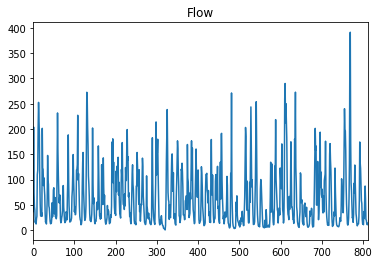

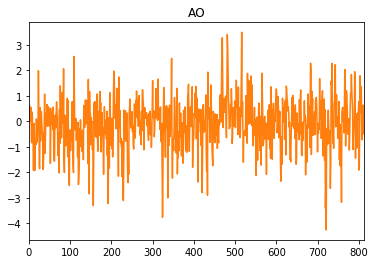

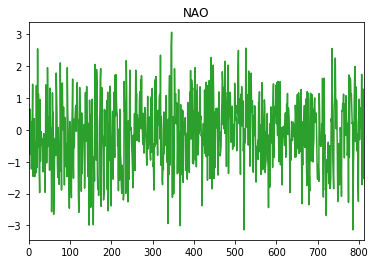

In [34]:
fig, ax = plt.subplots()
df.flow.plot(ax=ax, color=sns.color_palette()[0]);
ax.set_title('Flow')
fig, ax = plt.subplots()
df.AO.plot(ax=ax, color=sns.color_palette()[1]);
ax.set_title('AO')
fig, ax = plt.subplots()
df.NAO.plot(ax=ax, color=sns.color_palette()[2]);
ax.set_title('NAO')

## Import the regressors

**Here we import some standard regressors that are provided in the `regressors/` folder, but of course you can import your own regressors here as you please. In this example I import regressor data and interpolate on to the same time-grid as the imported data. For this example we import some standard indicies for: El Nino Southern Oscillation (ENSO), Solar activity (Solar), the Quasi-Biennial Oscillation (QBO; two indicies QBO30 and QBO50) and stratospheric aerosol optical depth (SAOD) for volcanic eruptions.**

**Again you can import the regressors however you like, but the result must be the following variable loaded into python:**

`regressors` np.array(N, nreg) *2d array with each column representing one regressor (evaluated on the same time-grid as your data)*

**Note: Missing values/NaNs in the regressors are not currently supported, please interpolate missing values so that they are all real valued. It is also good practice to normalize your regressors to be zero mean and have a range [-0.5, 0.5], so they are all on the same scale. Having regressors with wildly different scales can cause issues.**

## Set the data and initialization to be fed into the dlm

### `input_data`

**First we set the `input_data` - a dictionary of all the data and input parameters than the dlm model requires in order to run. The input data must have the following entries:**

- `time_series` np.array(N) *data vector (time-series to be analyzed)*<br/>
- `stddev` np.array(N) *standard deviation error bars for the time-series*<br/>
- `N` (int) *number of time-steps in the time-series ie., length of your data vector*<br/>
- `nreg` (int) *number of regressors*<br/>
- `regressors` np.array(N, nreg) *the regressors: 2D array of size (data vector length, number of regressors)*<br/>
- `sampling` (float) *sampling rate of the data: specify "daily", "monthly" or "annual" to the function sampling()*<br/>
- `S` (float) *variance of the Gaussian prior on the regression coefficients; set to 10 as default*<br/>
- `sigma_trend_prior` (float) *standard deviation of the half-Gaussian prior on* `sigma_trend` *that controls how wiggly the trend can be; set to 1e-4 as default*<br/>
- `sigma_seas_prior` (float) *standard deviation of the half-Gaussian prior on* `sigma_seas`, *controls how dynamic the seaonal cycle can be; set to 0.01 as default*<br/>
- `sigma_AR_prior` (float) *standard deviation of the half_Gaussian prior on the AR1 process's standard deviation; set to 0.5 as default*<br/>
- `sigma_reg_prior` np.array(nreg) *standard deviation of the half_Gaussian prior on* `sigma_reg` *parameters, controling how dynamic the regressor amplitudes can be (in time); set to 1e-4 for all as default*

**Note: You should leave out parameters that are not included in your model, eg, if you are running a model without dynamical regressors you can leave out `sigma_reg_prior`, or if you are running a model without regressors you can leave out `regressors`. See Table 1 of `models/model_descriptions.pdf` for details of which parameters are included for which models.**

**Units: Note that the std-deviation hyper-parameters (`sigma_trend`, `sigma_seas`, `sigma_AR` and `sigma_reg`) controlling how dynamic various components of the DLM model are, are defined in units of the range of the input data, ie, / (max(time_series) - min(time_series)). In this sense they define fractional standard-deviations wrt the data. This provides a common ground for defining priors on the dynamics hyper-parameters irrespective of the units of the data.**

### `initial_state`

**Second, we set the `initial_state` - a dictionary of initial guesses for the hyper-parameters for initializing the MCMC sampler. This must have the following entries (with sugegsted default values):**

`sigma_trend` (float) *initial value for* `sigma_trend`; *default to 0.0001*<br/>
`sigma_seas` (float) *initial value for* `sigma_seas`; *default to 0.001*<br/>
`sigma_AR` (float) *initial value for* `sigma_AR`; *default to 0.01*<br/>
`rhoAR1` (float) *initial value for* `rhoAR1`; *default to 0.1*<br/>
`rhoAR2` (float) *initial value for* `rhoAR2`; *default to 0*<br/>
`sigma_reg` np.array(nreg) *initial value for* `sigma_reg`; *default to 1e-4 for all*

**Note: Again, you can leave out parameters that are not included in your model, ie if you are running one of the AR1 models you do not need `rhoAR2`, and if you are running models without dynamical regressors you can leave out `sigma_reg`. See `models/model_descriptions.pdf` (Table 1) for details of which parameters are included for which models.**

In [49]:
regressors = np.matrix( df.AO.values).T
# regressors.shape
df.head()

,date,flow,flow_std,AMM,AMO,AO,NAO,NINO12,NINO3,NINO34,...,NP,NPI,ONI,PDO,PNA,PWP,SOI,TNA,TPI,TSA
0,1950-01-01,36.854839,7.938759,0.53,0.112,-0.060,0.56,23.01,23.56,24.55,...,1014.87,1014.87,-1.53,-2.13,-3.65,-0.382,NaN,-0.14,-1.12,0.08
1,1950-02-01,203.896429,59.782851,-1.07,-0.032,0.627,0.01,24.32,24.89,25.06,...,1010.40,1010.40,-1.34,-2.91,-1.69,-0.207,NaN,-0.36,-1.38,0.15
2,1950-03-01,73.916129,14.940506,-1.26,-0.104,-0.008,-0.78,25.11,26.36,25.87,...,1008.13,1008.13,-1.16,-1.13,-0.06,-0.110,NaN,-0.37,-1.09,0.12
3,1950-04-01,46.833333,20.282306,0.72,-0.129,0.555,0.65,23.63,26.44,26.28,...,1015.49,1015.49,-1.18,-1.20,-0.23,-0.126,NaN,-0.11,-1.10,-0.17
4,1950-05-01,39.703226,18.872652,1.05,-0.057,0.072,-0.50,22.68,25.69,26.18,...,1015.47,1015.47,-1.07,-2.23,-0.40,-0.145,NaN,-0.25,-1.28,-0.34


In [59]:
df.shape

(813, 21)

In [50]:
# Set the data and initialization of parameters that are fed into the DLM

# Input data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
input_data = {
                    'time_series':df.flow.values, # float[N] data vector
                    'stddev':df.flow_std.values, # float[N] std-dev error bars
                    'N':len(df.flow.values), # (int) number of time-steps in the time-series
                    'nreg':1, # (int) number of regressors
                    'regressors':regressors, # float[N, nreg] the regressors
                    'sampling':sampling_rate("monthly"), # must be "daily", "monthly", or "annual"
                    'S':10., # prior variance on the regression coefficients
                    'sigma_trend_prior':1e-4, # std-dev of the half-Gaussian prior on sigma_trend
                    'sigma_seas_prior':0.01, # std-dev of the half-Gaussian prior on sigma_seas
                    'sigma_AR_prior':0.5 # std-dev of the half_Gaussian prior on the AR1 process std-dev 
                }

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':0.0001,
                 'sigma_seas':0.001,
                 'sigma_AR':0.01,
                 'rhoAR1':0.1,
                }

## OK let's run the DLM!

**Now we're set up we can run the dlm. Below we run an HMC sampler (using `pystan`) together with Kalman filtering (and smoothing) steps to obtain samples from the joint posterior of the dlm model parameters given the input data and uncertainties, ie.,**

$P(nonlinear\;trend,\,seasonal\;cycle,\,AR\;process,\,regressor\;coefficients,\,hyperparameters | data)$

**The input parameters to the function `sampling()` below have the following meanings:**

`data` = *input data dictionary from above*<br/>
`iter` = *total number of MCMC samples to get; should be at least a few thousand*<br/>
`warmup` = *how many evaluations are allowed for the HMC sampler to "warm-up" (these are discarded in the final output)*<br/>
`chains` = *how many parallel chains to run? (see below for running parallel chains)*<br/>
`init` = *list of initial state dictionaries (from above), one per chain*<br/>
`pars` = *which parameters do you actually want to save as output in the results? (see below)*

**The `pars` parameter controls which parameters you want to save in the output results. You can choose any number from the following:**

`sigma_trend` (float) *hyper-parameter controlling how wiggly the trend can be*<br/>
`sigma_seas` (float) *hyper-parameter controlling how dynamic the seasonal cycle can be*<br/>
`sigma_AR` (float) *standard deviation parameter for the AR process*<br/>
`rhoAR1` (float) *first correlation parameter for the AR process*<br/>
`rhoAR2` (float) *second correlation parameter for the AR process*<br/>
`sigma_reg` np.array(nreg) *hyper-parameter controlling how dynamic the regressor amplitudes can be*<br/>
`beta` np.array(nreg, N) *dynamical regression coefficients*<br/>
`trend` np.array(N) *non-inear DLM trend (as function of time)*<br/> 
`slope` np.array(N) *slope of the non-linear DLM trend (as function of time)*<br/>
`seasonal` np.array(N) *seasonal cycle with 6- and 12- month components (as function of time)*<br/>
`ar` np.array(N) *fitted AR process (as function of time)*

**Note: you can only inlcude things in `pars` that are actually included in the model you are running. See Table 1 of `models/model_descriptions.pdf` for which parameters are available in each of the models.**

**NOTE: you should limit your output `pars` to things you really want to look at after to keep the output smaller - it will be faster to work with for making plots etc later on, and take up less memory. If you do not set pars it will automatically save everything by default.**

**Running multiple chains in parallel: It is easy to run multiple chains in parallel by simply setting `chains` > 1. If you do this you must also provide a list of initial state dictionaries to `init`, ie., `init` = [initial_state1, initial_state2, ...] (precicely one initial state per chain, and they need not be different although it is good practice to give the chains different starting points)**

**OK let's do it! NB it will take a few minutes to run so be patient**

In [56]:
# Ok, let's run it
while fit_ == True:
    fit_ = False
    fit = dlm_model.sampling(
        data=input_data, 
        iter=3000, 
        warmup=1000, 
        chains=1, 
        init = [initial_state], 
        verbose=True, 
        pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'rhoAR1', 'trend', 'slope', 'beta', 'seasonal')
    )

In [60]:
type(fit)
# fit

stanfit4anon_model_1769d29906593e8f6fa11e816b642cff_6174251494884883171.StanFit4Model

## Extract the results

**By this point, the `fit` object contains "n_samples = (iter - warmup) x chains" samples of each of the parameters in "pars" that you chose to output. To access the samples for any individual parameter, just do:**

parameter_samples = fit.extract()['insert parameter name here'] (see examples below)

**For example, if you do `fit.extract()['trend']` it will give an array `np.array(n_samples, N)`, n_samples
samples of the full DLM trend, which has lengh N.**

**All outputs from the fit object will have shape n_samples x dimension of variable (see above).**

**To make life easier for anlysing the results in the rest of the notebook, let's extract all the samples here in one go...**


In [63]:
# Extract the various bits from the fit-object. 

# Trend
trend = fit.extract()['trend'][:,:]

# Gradient of the DLM trend
slope = fit.extract()['slope'][:,:]

# Seasonal cycle
seasonal_cycle = fit.extract()['seasonal'][:,:]

# Regressor coefficients
regressor_coefficients = fit.extract()['beta']

# DLM hyper parameters
sigma_trend = fit.extract()['sigma_trend']
sigma_seas = fit.extract()['sigma_seas']
sigma_AR = fit.extract()['sigma_AR']
rhoAR1 = fit.extract()['rhoAR1']

## Finally, let's make some plots of the outputs!

**Obviously we can compute and plot whatever we like now we have the results, but let's make a few example plots of the various parameters we have inferred to showcase the results.**

### Let's start by plotting the recovered dlm trend and corresponding (1$\sigma$) uncertainties:

In [81]:
T = [i for i, t in enumerate(df.date)]
d = df.flow.values

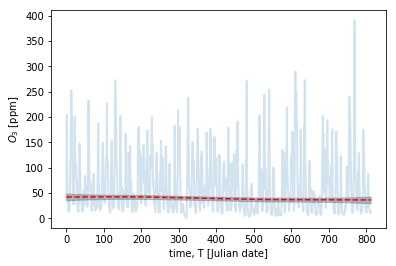

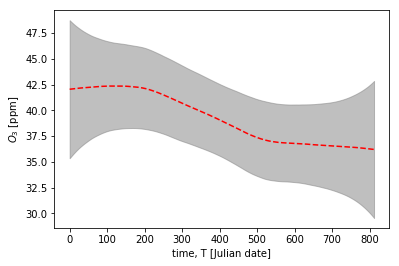

In [82]:
# Plot recovered trend against the data

# Plot the data
plt.plot(T, d, lw = 2, alpha = 0.2)

# Plot the mean trend
plt.plot(T, np.mean(trend, axis = 0), color = 'red', ls = '--')

# Plot a grey band showing the error on the extracted DLM trend
# NOTE: this includes the error on the shape of the trend, but also on the overall offset, so can look deceptively large
plt.fill_between(
    T, 
    np.mean(trend, axis = 0) - np.std(trend, axis = 0), 
    np.mean(trend, axis = 0) + np.std(trend, axis = 0), 
    color = 'grey', 
    alpha = 0.5
)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [ppm]')
plt.show()

# Same plot but without the data behind (for a closer look at the DLM trend)
plt.plot(T, np.mean(trend, axis = 0), color = 'red', ls = '--')
plt.fill_between(
    T, 
    np.mean(trend, axis = 0) - np.std(trend, axis = 0), 
    np.mean(trend, axis = 0) + np.std(trend, axis = 0), 
    color = 'grey', 
    alpha = 0.5
)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [ppm]')
plt.show()

### Now for the recovered seasonal cycle - note that modulation in the amplitude of the seasonal cycle is allowed in the dlm model (and here is preferred by the data):

ValueError: operands could not be broadcast together with shapes (100,) (813,) 

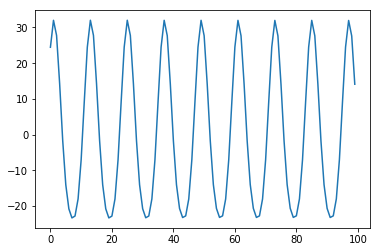

In [86]:
indices = [i for i in range(0, 100)]
# Plot the recovered seasonal cycle and uncertainties
plt.plot(T[0:100], np.mean(seasonal_cycle, axis = 0)[0:100])
plt.fill_between(T[0:100], np.mean(seasonal_cycle, axis = 0)[0:100] - np.std(seasonal_cycle, axis = 0), np.mean(seasonal_cycle, axis = 0) + np.std(seasonal_cycle, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel('seasonal cycle $O_3$ [ppm]')
plt.show()

# Regressors

In [89]:
beta = regressor_coefficients[:]

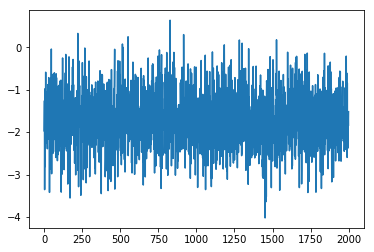

In [91]:
plt.plot([_ for _ in range(len(beta))], beta);
# kde([-0.01, 0, 0.01])

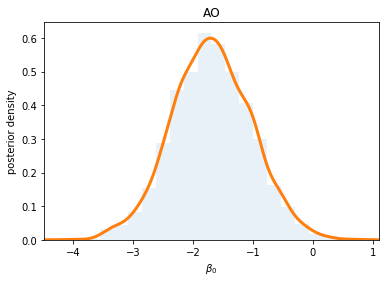

In [93]:
# Plot posteriors for the regression coefficients
regressor_names = ['AO']
for i in range(len(regressors.T)):
    beta = regressor_coefficients[:]
    kde = stats.gaussian_kde(beta)
    x = np.linspace(min(beta) - np.ptp(beta)*0.1, max(beta) + np.ptp(beta)*0.1, 300)
    plt.hist(beta, bins=20, density=True, alpha = 0.1)
    plt.plot(x, kde(x), lw = 3)
    plt.xlim(x[0], x[-1])
    plt.title(regressor_names[i])
    plt.ylabel('posterior density')
    plt.xlabel(r'$\beta_{}$'.format(i))
    plt.show()

### We can also plot histograms of the dlm hyper-parameter posteriors:

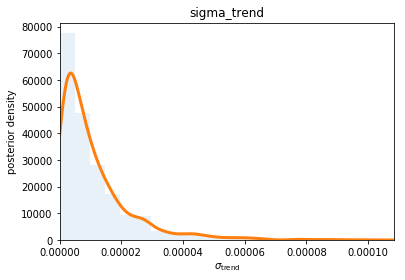

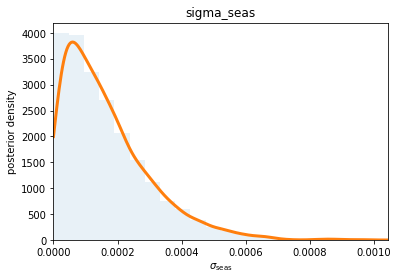

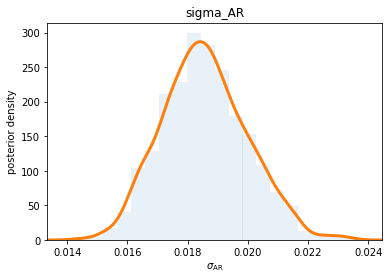

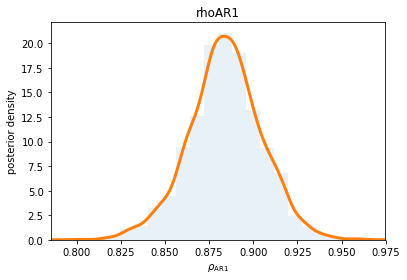

In [94]:
# Plot posteriors for the DLM hyper parameters
kde = stats.gaussian_kde(sigma_trend)
x = np.linspace(0, max(sigma_trend)*1.1, 300)
plt.hist(sigma_trend, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.show()

kde = stats.gaussian_kde(sigma_seas)
x = np.linspace(0, max(sigma_seas)*1.1, 300)
plt.hist(sigma_seas, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.show()

kde = stats.gaussian_kde(sigma_AR)
x = np.linspace(min(sigma_AR) - np.ptp(sigma_AR)*0.1, max(sigma_AR) + np.ptp(sigma_AR)*0.1, 300)
plt.hist(sigma_AR, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_AR')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.show()

kde = stats.gaussian_kde(rhoAR1)
x = np.linspace(min(rhoAR1) - np.ptp(rhoAR1)*0.1, max(rhoAR1) + np.ptp(rhoAR1)*0.1, 300)
plt.hist(rhoAR1, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('rhoAR1')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR1}$')
plt.show()

### Now for some trace plots of the MCMC samples of the hyper-parameters:

### This provides a good visual check of whether the chains have converged - if they look like noise it indicates that the chains are well converged, whilst if you see drifts in these trace plots then you need to go back and run longer chains (ie increase "iter" in the sampling() step above).

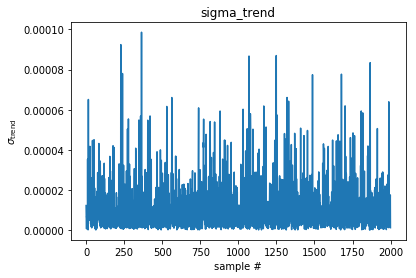

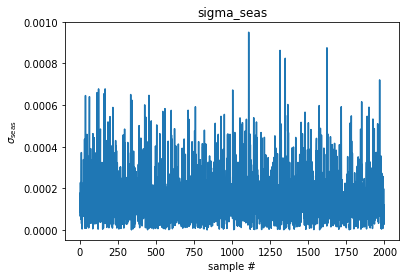

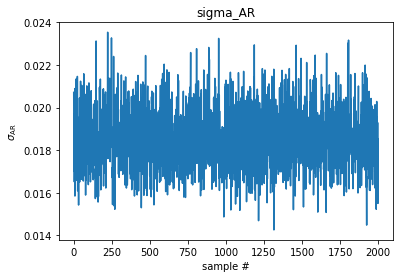

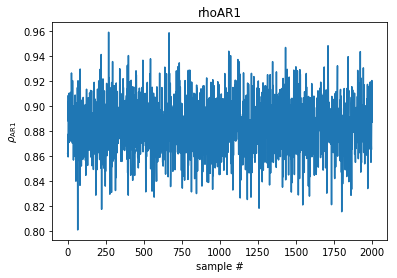

In [95]:
# Do trace plots of the MCMC chains of the hyper-parameters

plt.plot(sigma_trend)
plt.title('sigma_trend')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{trend}$')
plt.show()

plt.plot(sigma_seas)
plt.title('sigma_seas')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{seas}$')
plt.show()

plt.plot(sigma_AR)
plt.title('sigma_AR')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{AR}$')
plt.show()

plt.plot(rhoAR1)
plt.title('rhoAR1')
plt.xlabel('sample #')
plt.ylabel(r'$\rho_\mathrm{AR1}$')
plt.show()

### Finally, we can do things like plot the posterior for the backgorund change in flow between two key dates (here, January 1998 and December 2017)

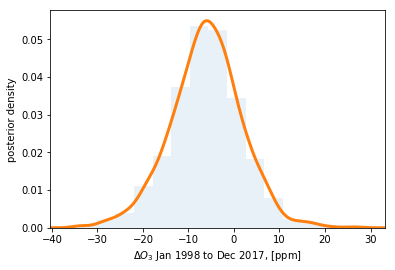

In [97]:
# Plot the posterior on the overall change in O3 between two dates eg, jan1998 and dec2017

# Time indices for the two dates
jan1998 = 156 # index of the T array corresponding to Jan 1998
dec2017 = -1 # (end of time series; december 2017)

# Construct MCMC samples for the change in O3 between those two dates by differencing the trend samples at those dates
deltaO3_jan1998_dec2017 = trend[:,dec2017] - trend[:,jan1998]

# Plot the histogram of the posterior samples of DeltaO3 between Jan 1998 and Dec 2017
kde = stats.gaussian_kde(deltaO3_jan1998_dec2017)
x = np.linspace(
    min(deltaO3_jan1998_dec2017) - np.ptp(deltaO3_jan1998_dec2017)*0.1, 
    max(deltaO3_jan1998_dec2017) + np.ptp(deltaO3_jan1998_dec2017)*0.1, 
    300
)
plt.hist(deltaO3_jan1998_dec2017, bins = 15, alpha = 0.1, density = True)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.xlabel(r'$\Delta O_3$ Jan 1998 to Dec 2017, [ppm]')
plt.ylabel('posterior density')
plt.show()

In [47]:
np.mean(deltaO3_jan1998_dec2017)

0.1514314218756751

## Congratulations, you made it to the end of the tutorial! 

## By now you should get the idea and, I hope, be able to use this notebook as a template for performing dlm regression on your own data. Good luck and happy DLMing!